# TOPIC MODELING USING -Embeddings, Semi-supervised Learning

> **AUTHOR**: RITIKA GUPTA<br>
**OBJECTIVE** : In this notebook we try to do topic modeling using one of the ebooks from Gutenburg Repository.
https://www.gutenberg.org/ebooks/search/?sort_order=downloads&start_index=51
We have chosen the book "Hounds Of Baskervilles" https://www.gutenberg.org/ebooks/2852 for the purpose of topic modeling and trying to find what are the major topics in the book.<br>

> **METHODS** : Following 

* Word2Vec
* CorEx (unsupervised)
* Anchored CorEx(Semi supervised)
* Top2Vec using word embeddings(unsupervised)

We use Word2Vec embeddings to visualise the words and and uncover patterns. Then use CorEx model to create unsupervised and anchored words semisupervised models. Also used Top2Vec Model which uses wordembeddings for topic modelling using clusterings. It is unsupervised approach.





In [1]:
import pandas as pd
#---------reading data
import urllib

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
import gensim.downloader as gensim_api

## Load Data
Use url of plain text "UTF-8" for the particular book to avoid pictures and have text only ebook

In [2]:
#Use url of plain text "UTF-8" for the particular book
url="https://www.gutenberg.org/files/2852/2852-0.txt"

#Custom function to read the book from url using URLLIB package
def load_gutenberg(target_url): 
  book= open('book_hounds.txt','w+')
  
  for line in urllib.request.urlopen(target_url):
    read_line=line.decode('utf-8')
    book.write(read_line) #write book in text file


In [5]:
#write txt
load_gutenberg(url)

#reading a part of book to check if write was successful
start_index=0
end_index=900
with open("book_hounds.txt") as file:
  file.seek(start_index)
  data = file.read(end_index - start_index)

print(data)

﻿The Project Gutenberg eBook of The Hound of the Baskervilles, by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Hound of the Baskervilles

Author: Arthur Conan Doyle

Release Date: October, 2001 [eBook #2852]
[Most recently updated: June 27, 2021]

Language: English

Character set encoding: UTF-8

Produced by: Shreevatsa R, and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK THE HOUND OF THE BASKERVILLES ***

cover 



THE HOUND OF THE BASKERVILLES

Another Ad


## Preprocess

In [7]:
# Preprocessor :  removing stopwords, stemming, lemmatization
import gensim
from gensim.utils import simple_preprocess   
from gensim.parsing.preprocessing import STOPWORDS

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, SnowballStemmer    
    
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))  # pos = "v" => only lemmatize verbs and leave nouns 'n' and adjectives 'a' alone
def preprocess(text):
    token_list = []
    for token in gensim.utils.simple_preprocess(text,min_len=4): # Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            token_list.append(lemmatize_stemming(token))
    #cleaned_line=" ".join(token_list)
    return token_list #nltk.tokenize.word_tokenize(token_list)

# Function to read file and convert each line of file as preprocessed tokens
def clean_text(data_path): 
  summaries = []  
  for line in open(data_path, encoding="utf-8"):
    summaries.append(preprocess(line))
  #Removing documents which have zero length  
  summaries=[line for line in summaries if len(line)>0]
  return summaries

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
data_path = "/content/book_hounds.txt"

#Calling custom function for cleaning and each line of text and converting each line to a document
#This function returns list of lines and each line as list of words(tokens)

summaries=clean_text(data_path)
print(summaries)


[['project', 'gutenberg', 'ebook', 'hound', 'baskervill', 'arthur', 'conan', 'doyl'], ['ebook', 'unit', 'state'], ['part', 'world', 'cost', 'restrict'], ['whatsoev', 'copi', 'away', 'term'], ['project', 'gutenberg', 'licens', 'includ', 'ebook', 'onlin'], ['gutenberg', 'locat', 'unit', 'state'], ['check', 'law', 'countri', 'locat'], ['ebook'], ['titl', 'hound', 'baskervill'], ['author', 'arthur', 'conan', 'doyl'], ['releas', 'date', 'octob', 'ebook'], ['recent', 'updat', 'june'], ['languag', 'english'], ['charact', 'encod'], ['produc', 'shreevatsa', 'david', 'widger'], ['start', 'project', 'gutenberg', 'ebook', 'hound', 'baskervill'], ['cover'], ['hound', 'baskervill'], ['adventur', 'sherlock', 'holm'], ['conan', 'doyl'], ['dear', 'robinson'], ['account', 'west', 'countri', 'legend', 'tale', 'owe'], ['incept', 'help', 'detail', 'thank'], ['truli'], ['conan', 'doyl'], ['hindhead'], ['haslemer'], ['content'], ['chapter', 'sherlock', 'holm'], ['chapter', 'curs', 'baskervill'], ['chapter', 

## Build Word2Vec Embeddings

In [9]:
## Train the genisim word2vec model with the vocabulary in the ebook 
## Each word represented in 50 dimension vector space using `size` parameter
model = Word2Vec(summaries, min_count=10,size= 50,workers=3, window =3, sg = 1)

WARNING - 02:22:44: consider setting layer size to a multiple of 4 for greater performance
INFO - 02:22:44: collecting all words and their counts
INFO - 02:22:44: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 02:22:44: collected 3681 word types from a corpus of 21648 raw words and 5927 sentences
INFO - 02:22:44: Loading a fresh vocabulary
INFO - 02:22:44: effective_min_count=10 retains 518 unique words (14% of original 3681, drops 3163)
INFO - 02:22:44: effective_min_count=10 leaves 13562 word corpus (62% of original 21648, drops 8086)
INFO - 02:22:44: deleting the raw counts dictionary of 3681 items
INFO - 02:22:44: sample=0.001 downsamples 95 most-common words
INFO - 02:22:44: downsampling leaves estimated 11133 word corpus (82.1% of prior 13562)
INFO - 02:22:44: estimated required memory for 518 words and 50 dimensions: 466200 bytes
INFO - 02:22:44: resetting layer weights
INFO - 02:22:44: training model with 3 workers on 518 vocabulary and 50 features, us

In [15]:
print(model.corpus_total_words) # This is total corpus of words
print(len(list(model.wv.vocab))) # This is number of words for which our model trained on which is from ebook
print(list(model.wv.vocab)[50:60])

#index=model.wv.index2word
#word_vectors=model[index]
#we can check vector embedding for our  ebook word
model['hound'] #50 dimension

21648
518
['tabl', 'stand', 'stick', 'visitor', 'leav', 'head', 'know', 'broad', 'silver', 'near']


array([-0.01936569, -0.04465214, -0.05038765,  0.03581476,  0.10646861,
       -0.09481627,  0.1242286 , -0.01735097,  0.02625708,  0.01128864,
       -0.04566248,  0.00832158,  0.04074627,  0.12809892,  0.02800631,
        0.08543995,  0.04006793, -0.07769884,  0.00185599,  0.08584643,
        0.04674834,  0.08756004,  0.01299792, -0.01461584, -0.05591938,
        0.11065844, -0.02085046, -0.05185179, -0.01462957,  0.01238445,
        0.00842266,  0.00806029, -0.01004172,  0.11010072,  0.00730194,
        0.06406641,  0.02916602, -0.05885968, -0.05446618, -0.05856454,
        0.01387233,  0.03332509, -0.12063529, -0.03774196, -0.01067892,
       -0.05048536, -0.00200573,  0.05555842,  0.06589657, -0.00602862],
      dtype=float32)

## Plot Word2Vec

Below we define a function to plot of embeddings using TSNE in 2 dimensional space

In [17]:
#custom function to create a tsne visualization
def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

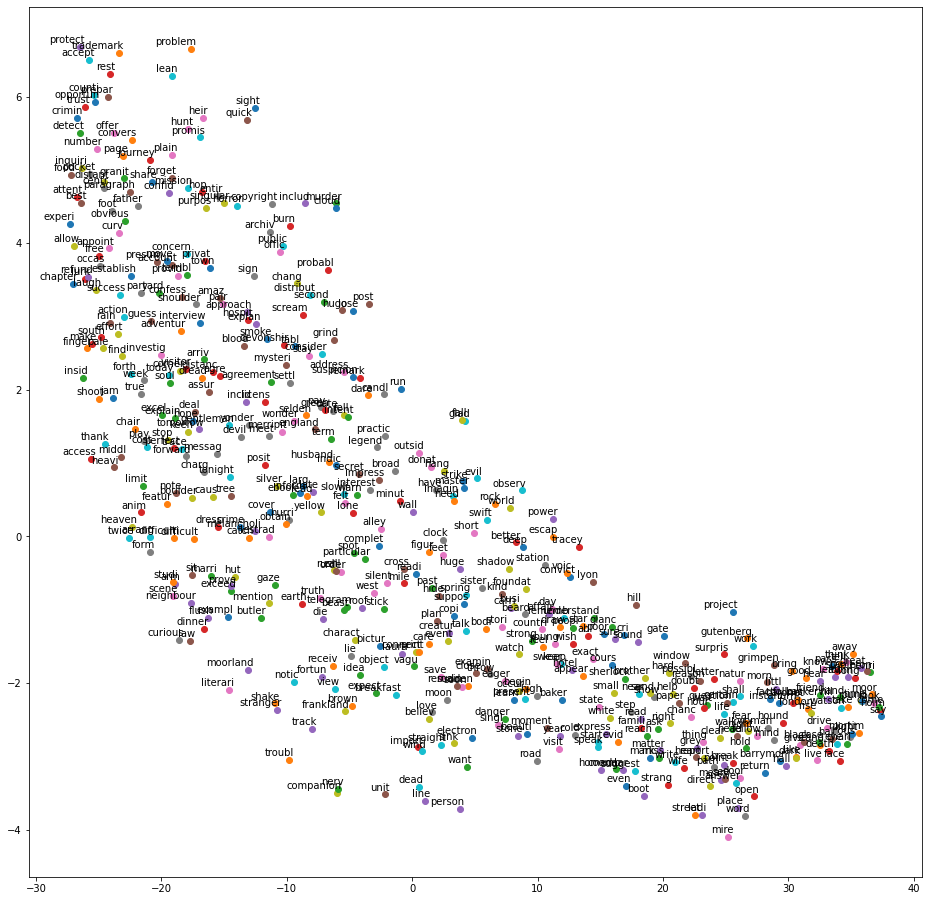

In [18]:
%matplotlib inline
tsne_plot(model)

From the plot above we can see that the word vectors are clustered based on the usage in ebook instead of generic semantic similarity. For example at (20,-1) we see project appearing near to gutenberg as it is mentioned together in ebook. 

To improve our embeddings we can incorporate the vectors present in pretrained word2vec models and use it for the words in our ebook.This will help us in generlaise our embeddings further instead of focussing only on usage in book .

In [30]:
#CHecking words similar
model.wv.most_similar('evil')

INFO - 03:08:44: precomputing L2-norms of word weight vectors


[('enemies', 0.8058041334152222),
 ('mortal', 0.7750170230865479),
 ('god', 0.7451233267784119),
 ('beast', 0.7345728874206543),
 ('wicked', 0.7336525321006775),
 ('beings', 0.7286164164543152),
 ('true', 0.7275856733322144),
 ('demonic', 0.7254882454872131),
 ('villain', 0.7204681634902954),
 ('immortal', 0.7162662148475647)]

## Merging pretrained embeddings and book embeddings

Refer this link : https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html


In [20]:
from gensim.models import KeyedVectors
import gensim.downloader as api

#setting return_path true to get path of where model is downloaded
path = api.load('glove-wiki-gigaword-50', return_path=True) #we use the gensim api to download the pretrained embeddings


INFO - 02:39:08: Creating /root/gensim-data


[==================================================] 100.0% 66.0/66.0MB downloaded


INFO - 02:39:30: glove-wiki-gigaword-50 downloaded


In [21]:
path #check path

'/root/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz'

* We here build our vocabulary using book words `summaries`
* Then we load the pretrained embeeding using `KeyedVectors` setting binary `false`
The structure is called “KeyedVectors” and is essentially a mapping between keys and vectors. Each vector is identified by its lookup key, most often a short string token, so this is usually a mapping between `{str => 1D numpy array}.`

* Use the pretrained vectors to model and update the vocabulary with pretrained vectors so we can generalise our embeddings and incorporate semantic information from larger corpus. Ex- hound ,beast these are similar words and should appear close.

`intersect_word2vec_format`<br>
*Merge the input-hidden weight matrix from the original C word2vec-tool format given, where it intersects with the current vocabulary. (No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.)*

*`binary` is a boolean indicating whether the data is in binary word2vec format.*

*`lockf` is a lock-factor value to be set for any imported word-vectors; the default value of 0.0 prevents further updating of the vector during subsequent training. Use 1.0 to allow further training updates of merged vectors.*





>  Refer for KeyedVectors:
https://radimrehurek.com/gensim/models/keyedvectors.html
<br>Refer for Intersecting Words
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.intersect_word2vec_format.html


*


In [ ]:
model_2 = Word2Vec(size=50, min_count=10) #we reduce min count here so that we can get less words to visualise properly 
model_2.build_vocab(summaries)
total_examples = model_2.corpus_count
model = KeyedVectors.load_word2vec_format(path, binary=False)
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(path, binary=False, lockf=1.0)
model_2.train(summaries, total_examples=total_examples, epochs=model_2.iter)

In [27]:
print('Words in our ebook vocabulary',len(list(model_2.wv.vocab)))
print('Words in pretrained vocabulary',len(list(model.vocab.keys())))

Words in our ebook vocabulary 518
Words in pretrained vocabulary 400000


In [25]:
list(model.vocab.keys())[100:120]

['so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 'between',
 'did']

In [29]:
model_2.wv.most_similar('evil') #we can see our embeddings have changed and we are getting more semantically related words

[('beast', 0.737785816192627),
 ('true', 0.7354041934013367),
 ('truth', 0.6975628733634949),
 ('love', 0.664699912071228),
 ('heaven', 0.6626293063163757),
 ('mind', 0.6548440456390381),
 ('kind', 0.6494747996330261),
 ('devil', 0.6484829783439636),
 ('shadow', 0.6387596726417542),
 ('life', 0.6322659850120544)]

In [31]:
model_2.wv.most_similar('sherlock')

[('beast', 0.5652300715446472),
 ('horror', 0.5601990222930908),
 ('watson', 0.5245679020881653),
 ('legend', 0.47491005063056946),
 ('companion', 0.47323283553123474),
 ('write', 0.4730795621871948),
 ('stranger', 0.47187894582748413),
 ('page', 0.47068455815315247),
 ('hound', 0.46012505888938904),
 ('read', 0.44812554121017456)]

In [32]:
model_2.wv.most_similar('crime')

[('murder', 0.7632208466529846),
 ('case', 0.7231571674346924),
 ('action', 0.7140235304832458),
 ('suspicion', 0.6497434377670288),
 ('law', 0.6432519555091858),
 ('fact', 0.631881594657898),
 ('public', 0.6275901794433594),
 ('intent', 0.6255601644515991),
 ('life', 0.6196460723876953),
 ('scene', 0.6187838315963745)]

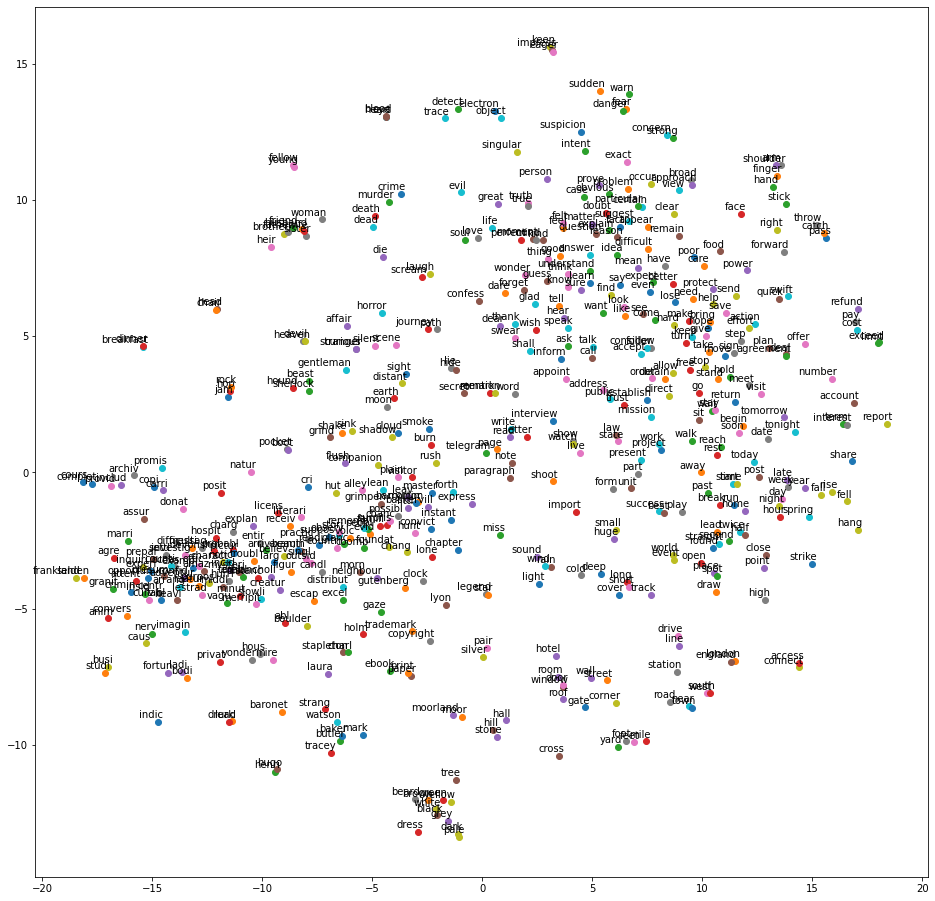

In [33]:
%matplotlib inline
tsne_plot(model_2)

### Analysing plot

From above plot we can we are getting embedding with more semantic information : words like "yellow,brown,black grey ,dress" clustered together at bottom.

Similarly words like crime ,murder,death,dead,die are clustered together.
At (-10,5) coordinates  we can see information with context to book is also captured we can "sherlock,hound,beast gentlemen" appear together ,since in book sherlock was involved in search of hound hence "sherlock" appears often with the word "hound".

In [ ]:
model_2 = Word2Vec(size=50, min_count=3) #we increase min count here to get more words from ebook 
model_2.build_vocab(summaries)
total_examples = model_2.corpus_count
model = KeyedVectors.load_word2vec_format(path, binary=False)
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(path, binary=False, lockf=1.0)
model_2.train(summaries, total_examples=total_examples, epochs=model_2.iter)

In [36]:
len(list(model_2.wv.vocab)) #total words from book in our model

1582

**Mathematical analysis**

We can uncover interesting patterns using the mathematical analysis of word2vec model by doing algebraic subtraction addition of word vectors.

Below we see adding vectors of "sherlock,watson and hound" we land near words of : dog,conan,book.

If we subtract the vector "beast"from above we land nearer to word vectors related to sherlock and watson such as stapleton ,johnson,butler,author ,friend which are all characters involved in the book . 

Thus we can observe getting relevant semantic as well as contextual information

In [37]:
model_2.wv.most_similar(positive=['sherlock','watson','hound'],topn=15)

INFO - 03:27:20: precomputing L2-norms of word weight vectors


[('dog', 0.7038281559944153),
 ('book', 0.6836475729942322),
 ('doyl', 0.6824174523353577),
 ('appreci', 0.6800753474235535),
 ('conan', 0.6792649626731873),
 ('typewrit', 0.6746513247489929),
 ('stimul', 0.6714797019958496),
 ('horribl', 0.6662558913230896),
 ('mortim', 0.6650987267494202),
 ('beast', 0.6626288294792175),
 ('excus', 0.6599715352058411),
 ('messag', 0.653891384601593),
 ('pressur', 0.6524182558059692),
 ('emerg', 0.6517944931983948),
 ('exclam', 0.6495823264122009)]

In [38]:
model_2.wv.most_similar(positive=['sherlock','watson','hound'],negative=['beast'])

[('john', 0.6838750839233398),
 ('butler', 0.6608808040618896),
 ('johnson', 0.6580041646957397),
 ('baker', 0.6552021503448486),
 ('porter', 0.6235371232032776),
 ('friend', 0.6021449565887451),
 ('author', 0.595085084438324),
 ('book', 0.5924614667892456),
 ('stapleton', 0.5801497101783752),
 ('conan', 0.5796936750411987)]

## Semi-Supervised Learning Using CorEx

Here we use the Correlation Explanation model for topic modelling.

In [39]:
!pip install corextopic

In [41]:
import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice
import scipy.sparse as ss
from sklearn.feature_extraction.text import  TfidfVectorizer

In [44]:
#Converting tokens of each line into a single line string
docs=[" ".join(lis) for lis in summaries]
docs[1:10]

['ebook unit state',
 'part world cost restrict',
 'whatsoev copi away term',
 'project gutenberg licens includ ebook onlin',
 'gutenberg locat unit state',
 'check law countri locat',
 'ebook',
 'titl hound baskervill',
 'author arthur conan doyl']

In [45]:
#Vectorize
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
doc_word = vectorizer.fit_transform(docs)
doc_word = ss.csr_matrix(doc_word)


In [46]:
doc_word

<5927x3646 sparse matrix of type '<class 'numpy.float64'>'
	with 21013 stored elements in Compressed Sparse Row format>

In [47]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [48]:
# Train the CorEx topic model with 20 topics
topic_model = ct.Corex(n_hidden=20, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [50]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=0, n_words=20)

[('gutenberg', 0.02153640949004225, 1.0),
 ('project', 0.01801647104311462, 1.0),
 ('work', 0.01178625430451927, 1.0),
 ('electron', 0.007406793673954284, 1.0),
 ('foundat', 0.006632369821444164, 1.0),
 ('copi', 0.005986682457558694, 1.0),
 ('term', 0.005898731498789613, 1.0),
 ('distribut', 0.005664333446886798, 1.0),
 ('licens', 0.00556361768553281, 1.0),
 ('state', 0.0049744727215029275, 1.0),
 ('paragraph', 0.004754805563304796, 1.0),
 ('agreement', 0.004505675906049884, 1.0),
 ('ebook', 0.00447572738737833, 1.0),
 ('copyright', 0.00432985239014429, 1.0),
 ('donat', 0.00428401745873014, 1.0),
 ('trademark', 0.004031702327070976, 1.0),
 ('archiv', 0.003831064186362416, 1.0),
 ('literari', 0.003752232473971251, 1.0),
 ('provid', 0.003286980242560435, 1.0),
 ('access', 0.003158949437312801, 1.0)]

In [51]:
 #Print all topics from the CorEx topic model
topics = topic_model.get_topics(n_words=20)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: gutenberg, project, work, electron, foundat, copi, term, distribut, licens, state, paragraph, agreement, ebook, copyright, donat, trademark, archiv, literari, provid, access
1: doyl, conan, altogeth, mastiff, guest, russet, pack, daunt, terrier, custom, fourth, jut, arthur, sprinkl, giant, farthest, drink, irregular, wilder, progress
2: finger, coat, glare, slope, tip, dark, impass, green, shine, grass, silver, curv, bright, exult, white, squar, eye, grey, roll, bristl
3: wear, suit, astonish, brown, tweed, ruddi, buy, thirti, statu, pair, tangl, expans, gold, raven, prefer, mare, instinct, black, infern, african
4: anxieti, desert, charm, excus, generos, caution, regard, affect, blackmail, deed, oblig, profess, hast, identifi, solitud, delicaci, curios, coupl, respect, appeal
5: concentr, flash, carriag, atmospher, len, coron, nois, curious, prosaic, fierc, trespass, crisp, genius, mental, organ, morland, juri, member, class, patholog
6: impati, valley, wagonett, block, avenu, swin

### Document Probabilities

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [52]:
# Probability of Topics for each Document 
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(5927, 20)


We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through labels.

In [53]:
print(topic_model.labels.shape) # n_docs x k_topics

(5927, 20)


Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

### Total Correlation and Model Selection

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.

In [54]:
topic_model.tc

0.1328551648551615

As we can see above the model's total correlation is very low . we will try to improve this using Anchoring of words.

### TC for each Topic
The overall total correlation is the sum of the total correlation per each topic. These can be accessed through tcs. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [55]:
topic_model.tcs.shape # k_topics

(20,)

### Selection of Number of Topic 
One way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

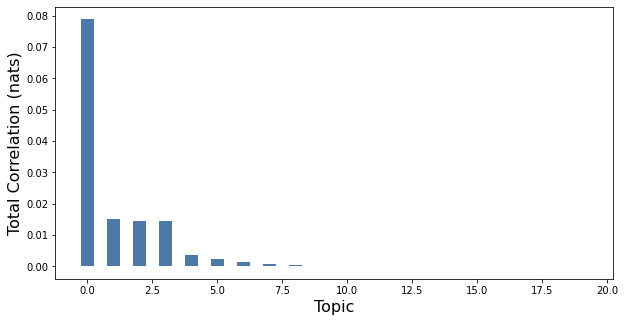

In [56]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

### Using Anchored Words for Semi-Supervised learning in Cor-Ex

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

As we observed above in Correlation graph of each we can see beyond 5 topic correlation degrades or contributes very little

In [57]:
# Anchor few word to the first topic
anchor_words = ['hound','beast','spaniel']

In [58]:
# Anchor the word 'hound','beast','spaniel' to the first topic
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [59]:
topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=0))
print('0: ' + ', '.join(topic_words))

0: hound, conan, doyl, hell, advanc, bay, infern, origin, baskervill, soil


As we saw above we anchored words related to 'Animal' topic to first topic 0 in the model.

We will now anchor we more words related to topics "Animal","Landscapes","Thriller/Crime" ,"Colors"

In [60]:
#anchoring few more words  for each subsequent topics
anchor_words = [['hound','beast','spaniel'],['moor','grass','moorland'],['crime','suspicion','evil'],['yellow','grey','black']]

In [62]:
# Anchor the word 'nasa' to the first topic
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [63]:
 #Print all topics from the CorEx topic model
topics = anchored_topic_model.get_topics(n_words=20)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: hound, beast, spaniel, conan, doyl, hell, advanc, bay, origin, baskervill, jove, arthur, bite, tale, mortal, correspond, nurseri, immacul, gloss, bogi
1: moor, moorland, grass, gate, shepherd, summer, sheep, curv, path, fleck, cotton, wander, loos, expans, slink, lush, survey, tumbl, stoni, dusk
2: evil, suspicion, crime, commit, sore, convert, instinct, trespass, morland, power, aid, skirt, comput, furi, suffici, riches_, refresh, unfurnish, unoccupi, energet
3: black, grey, yellow, beard, loss, charm, statu, haze, daunt, flame, tini, straw, soil, lawyer, rafter, foam, baulk, patholog, seal, doom
4: arrest, postmast, concentr, deni, desmond, test, tool, faith, preserv, list, hast, steel, document, clergyman, telegram, crisp, foeman, mental, argument, jam
5: gutenberg, project, work, electron, foundat, copi, term, licens, distribut, agreement, state, paragraph, ebook, copyright, donat, trademark, archiv, literari, access, compli
6: barrow, carriag, shut, neolith, pack, pace, prefer,

In [64]:
anchored_topic_model.tc

0.605505300490359

As we can see the total correlation score increased for our model from 0.13 to 0.60

## Top2Vec : Using word embeddings for unsupervised learning

In [65]:
!pip install top2vec

     |████████████████████████████████| 5.2 MB 41.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330858 sha256=24c544ed0166314f72f1998cacdac595a676ee0ff0d1b1fd2ed85a44950d140a
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=e6f1322d8f9bb3e088686c6cdb55f1ceb3d20f4c710ff5f907ea2f53f2fb2e2c
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=257da0f75eaaa52d3999efb47e9582754fca3c402c083690eaa25c24b644b26d
  St

In [66]:
!pip install top2vec[sentence_encoders]

     |████████████████████████████████| 4.9 MB 12.1 MB/s 
     |████████████████████████████████| 462 kB 50.3 MB/s 


In [67]:
from top2vec import Top2Vec
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

2022-03-10 03:39:56,385 - top2vec - INFO - Pre-processing documents for training
INFO - 03:39:56: Pre-processing documents for training
2022-03-10 03:39:56,667 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO - 03:39:56: Downloading universal-sentence-encoder model
INFO - 03:39:56: Using /tmp/tfhub_modules to cache modules.
INFO - 03:39:56: Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO - 03:40:12: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 740.00MB
INFO - 03:40:15: Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO - 03:40:15: Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2022-03-10 03:40:20,747 - top2vec - INFO - Creating joint document/word embedding
INFO - 03:40:20: Creating joint document/word embedding
2022-03-10 03:40:21,845 - top2vec - INFO - Creating lower dimension embedding of documents
INFO - 03:40:21: Creating low

In [ ]:
model.get_num_topics()

82

In [ ]:
model.topic_words

array([['barrymor', 'moor', 'hound', ..., 'place', 'take', 'littl'],
       ['barrymor', 'mortim', 'charl', ..., 'great', 'place', 'take'],
       ['charl', 'barrymor', 'mortim', ..., 'think', 'night', 'friend'],
       ...,
       ['mind', 'give', 'matter', ..., 'place', 'littl', 'holm'],
       ['dark', 'barrymor', 'face', ..., 'think', 'take', 'littl'],
       ['hound', 'barrymor', 'baskervill', ..., 'face', 'matter', 'like']],
      dtype='<U10')

In [ ]:
#Heirarchical Topic Reduction
topic_mapping = model.hierarchical_topic_reduction(num_topics=10)

In [ ]:
#List words of new merged topic
for i in range(0,10):
  print(model.topic_words_reduced[i])

['barrymor' 'moor' 'dark' 'eye' 'hound' 'stand' 'light' 'hall' 'walk'
 'face' 'mind' 'away' 'baskervill' 'turn' 'night' 'look' 'round' 'hand'
 'hous' 'long' 'mortim' 'death' 'leav' 'word' 'come' 'watson' 'go'
 'matter' 'tell' 'time' 'henri' 'case' 'charl' 'friend' 'hear' 'help'
 'good' 'say' 'take' 'place' 'think' 'give' 'gutenberg' 'mean' 'holm'
 'work' 'stapleton' 'know' 'great' 'thing']
['barrymor' 'hound' 'death' 'moor' 'baskervill' 'holm' 'mind' 'dark'
 'walk' 'charl' 'mortim' 'away' 'face' 'eye' 'stand' 'word' 'say' 'hear'
 'turn' 'tell' 'think' 'look' 'watson' 'night' 'know' 'long' 'round'
 'hous' 'hand' 'go' 'come' 'good' 'gutenberg' 'help' 'mean' 'give'
 'matter' 'light' 'case' 'hall' 'leav' 'henri' 'friend' 'stapleton' 'time'
 'take' 'great' 'thing' 'place' 'work']
['tell' 'hear' 'mind' 'say' 'know' 'friend' 'word' 'look' 'give' 'help'
 'stand' 'take' 'barrymor' 'good' 'go' 'hound' 'baskervill' 'think' 'eye'
 'matter' 'walk' 'long' 'come' 'turn' 'time' 'hand' 'face' 'great' '

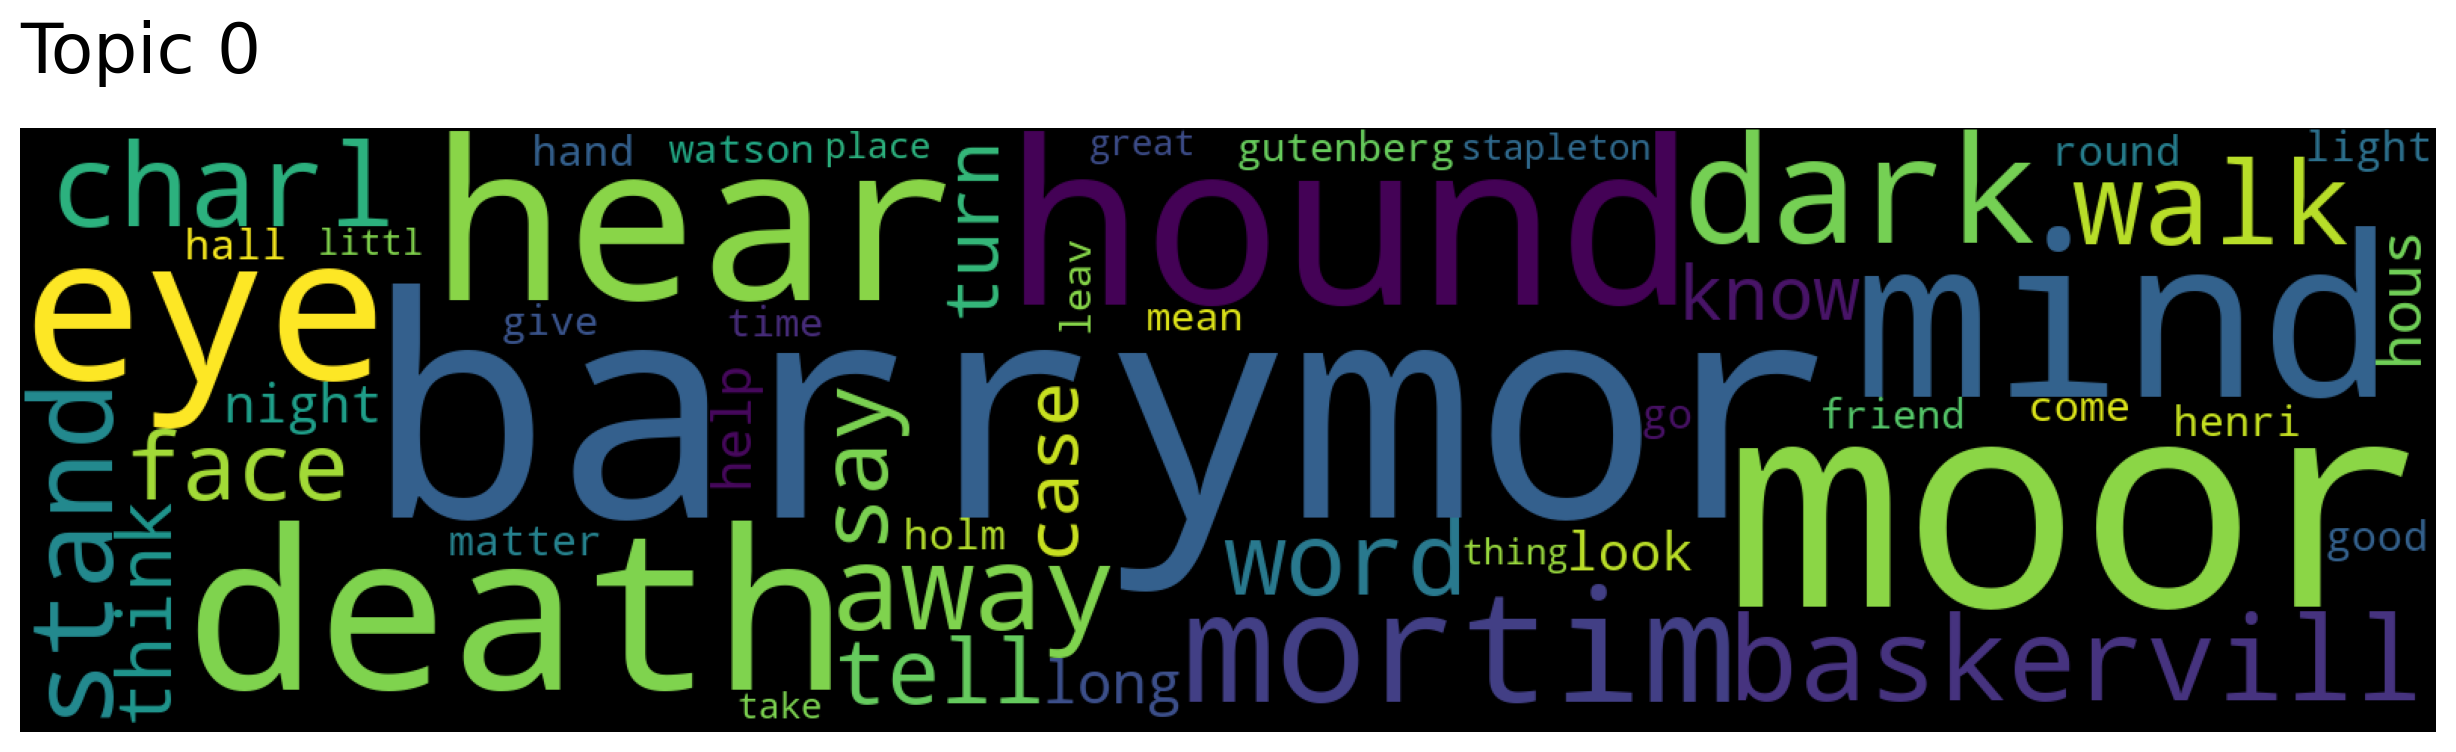

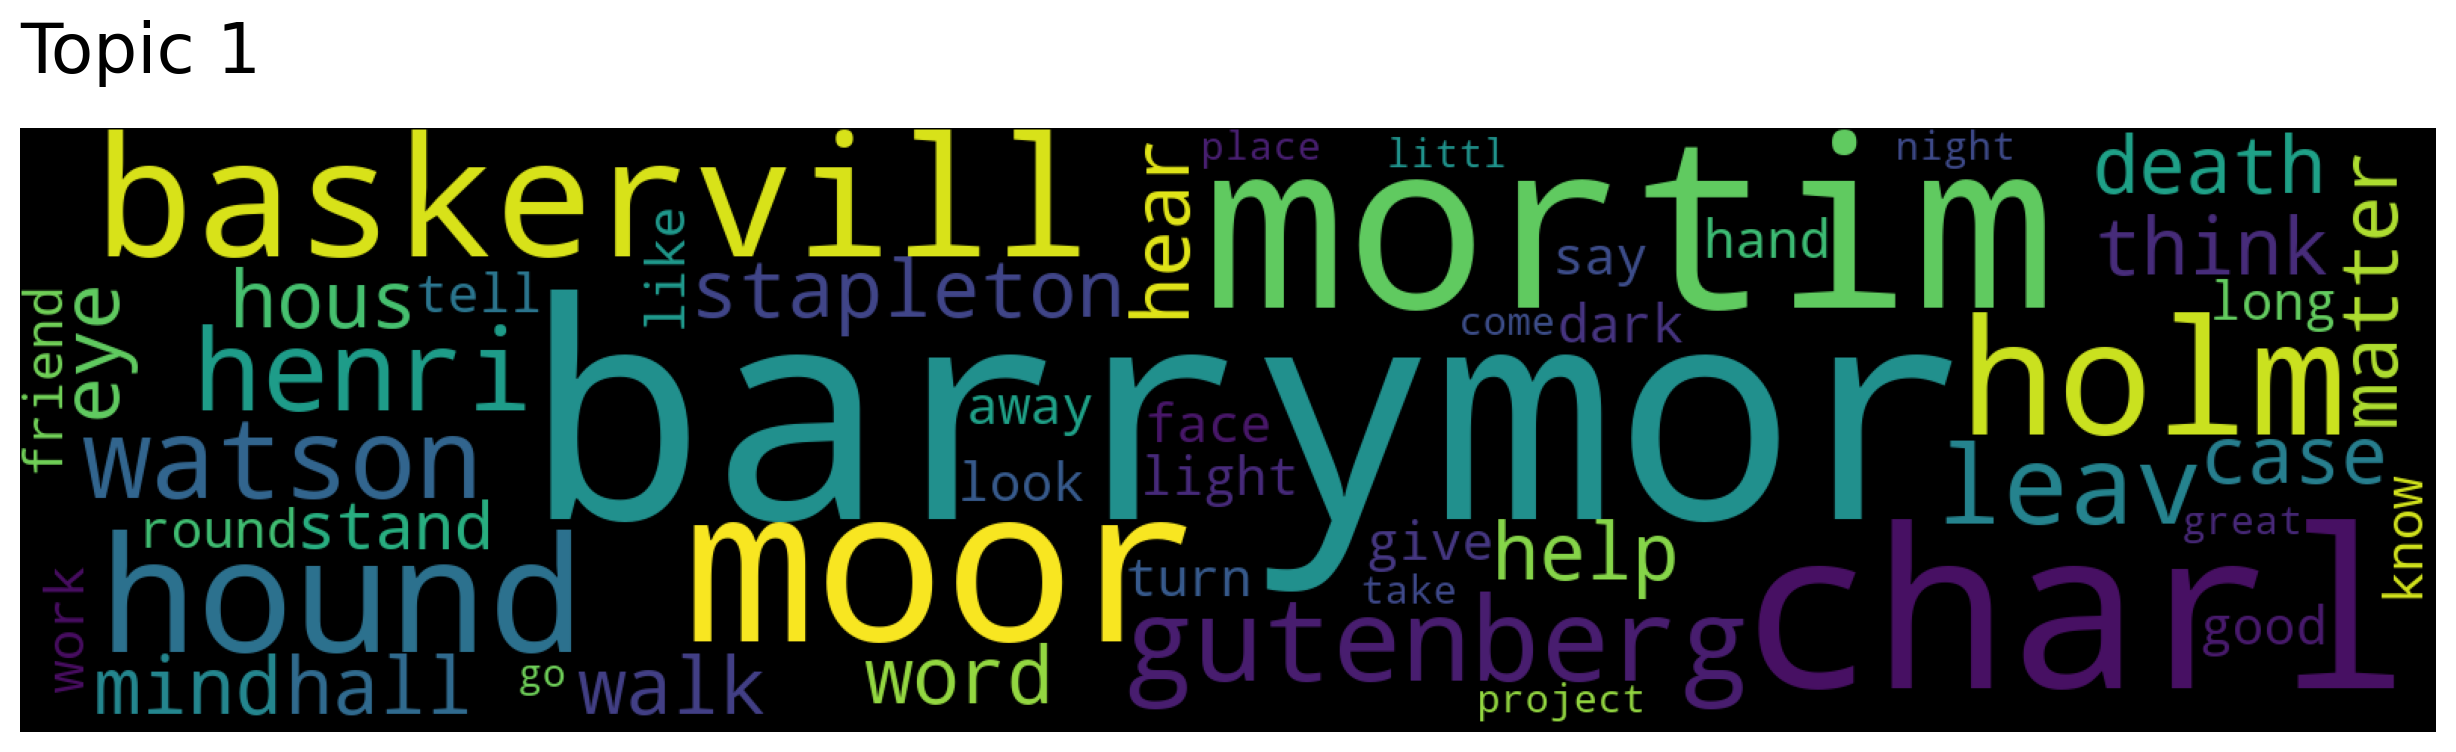

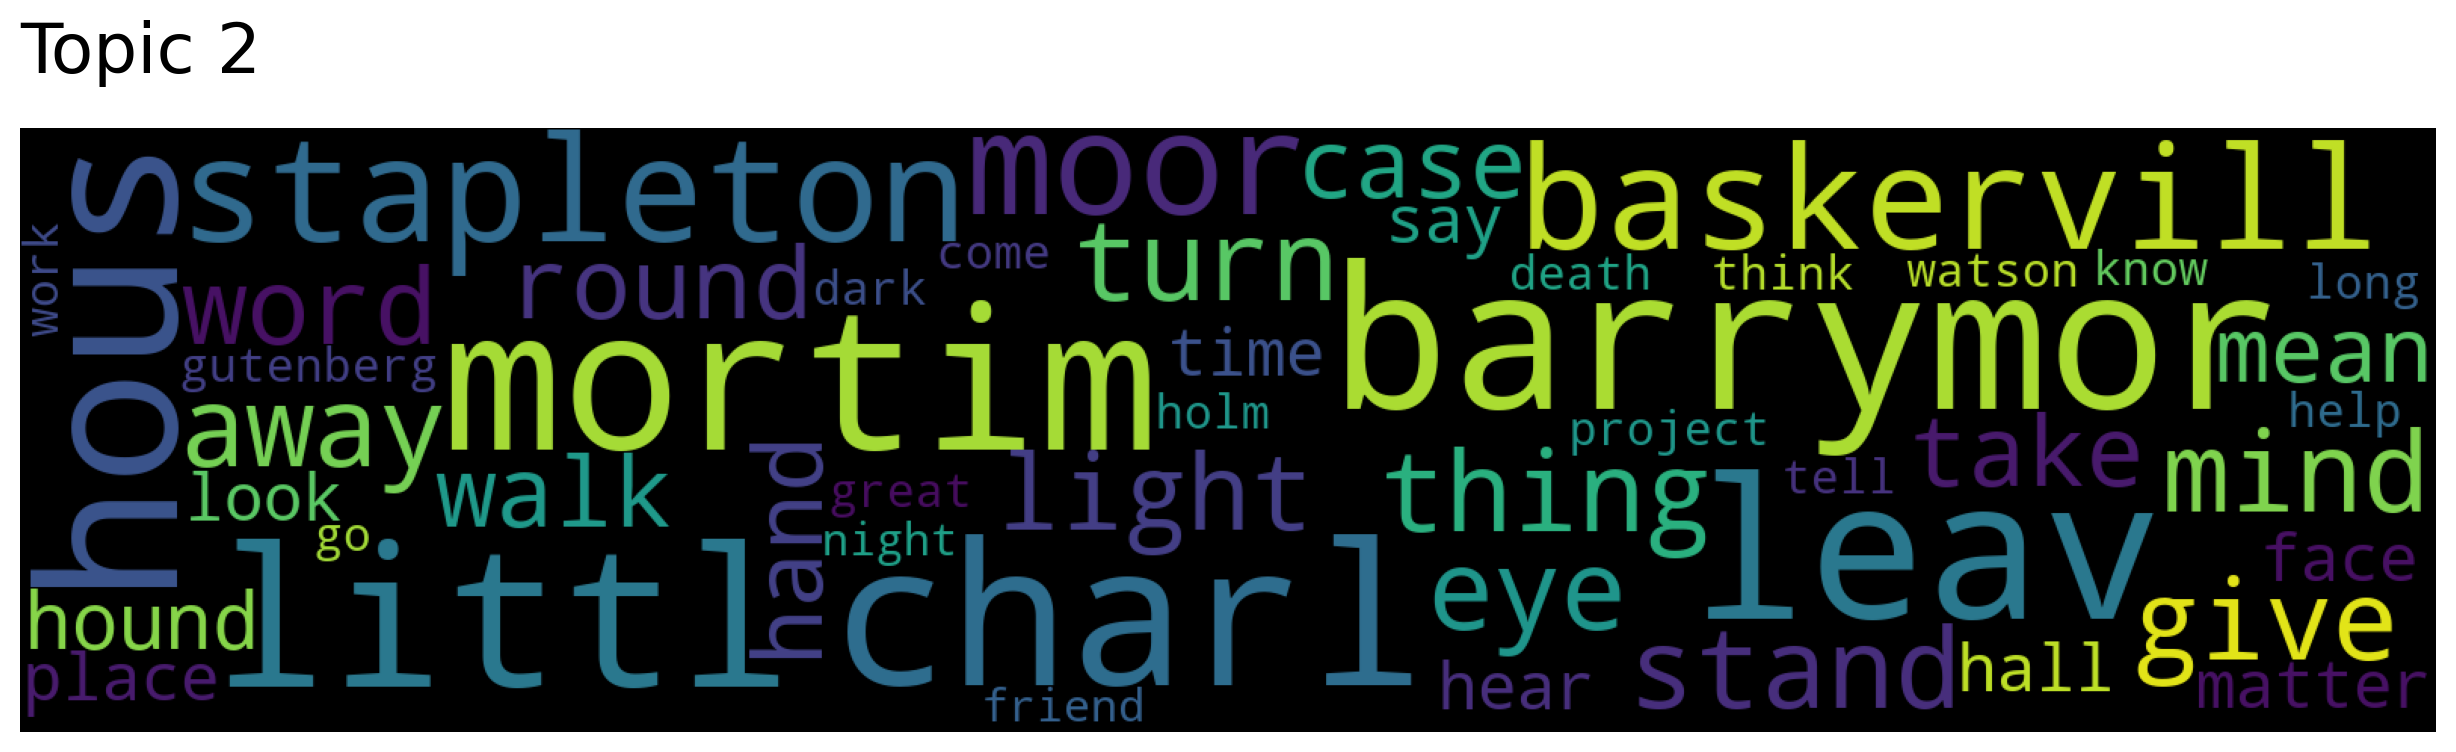

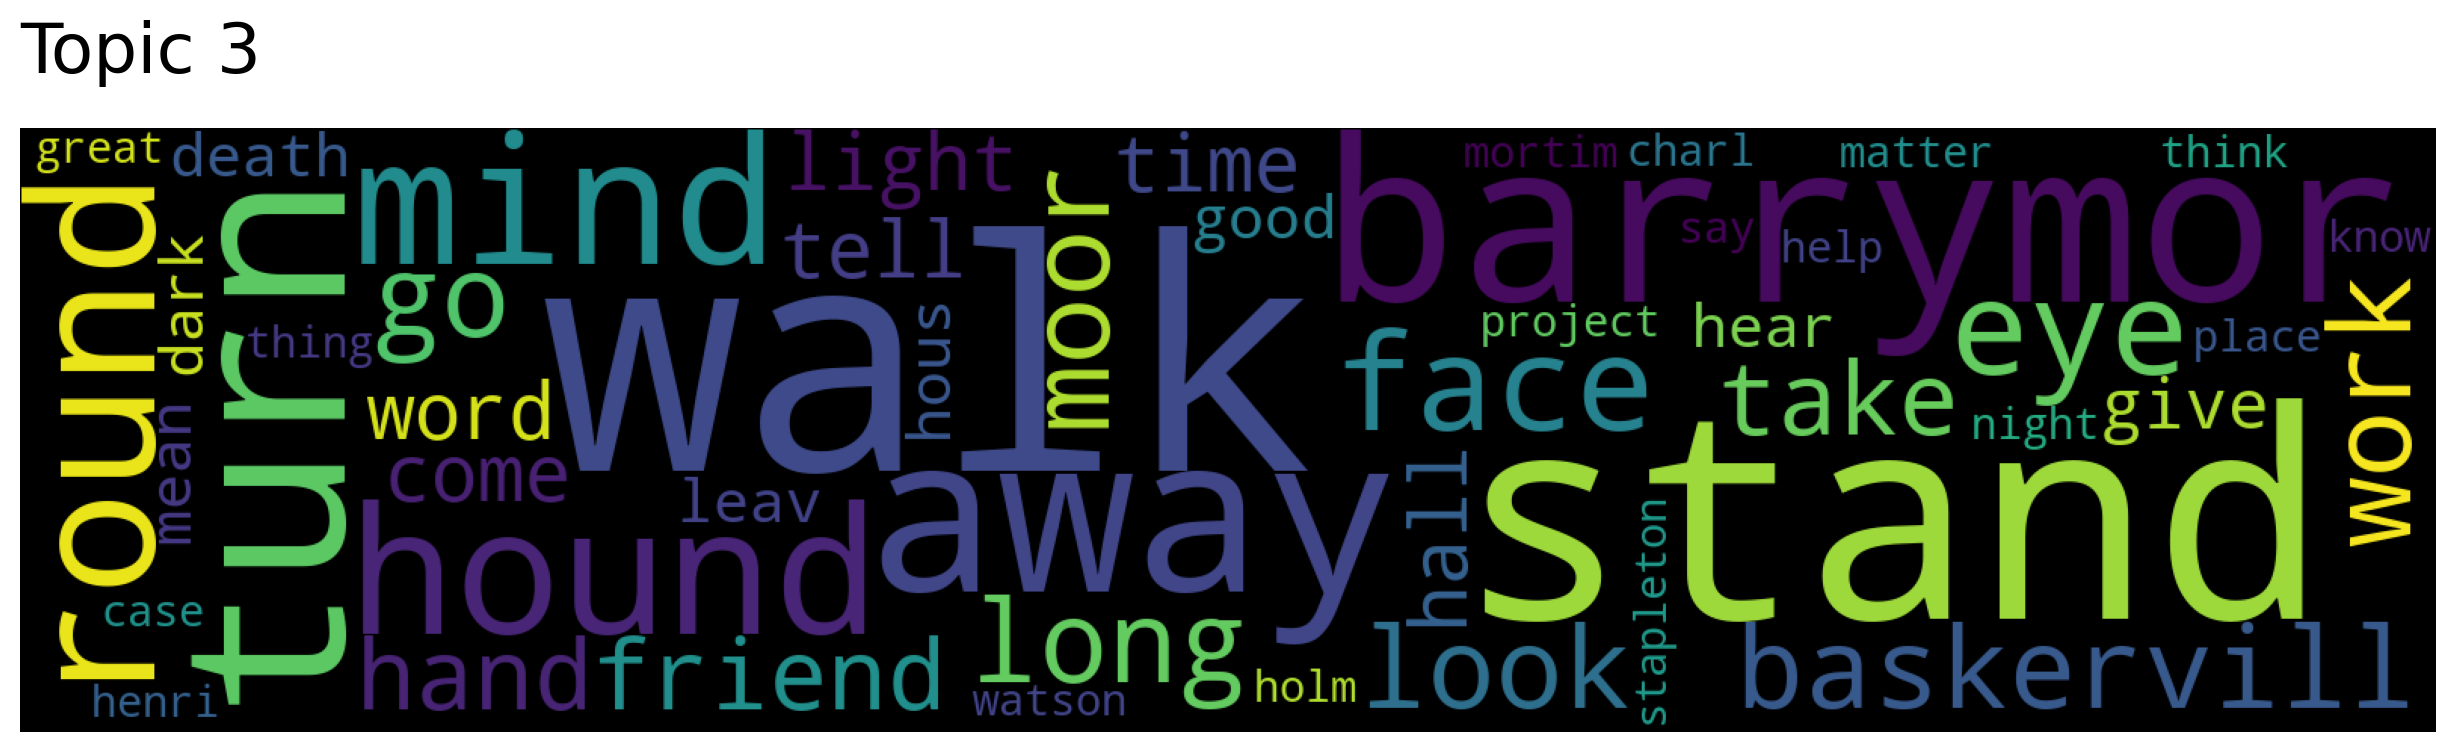

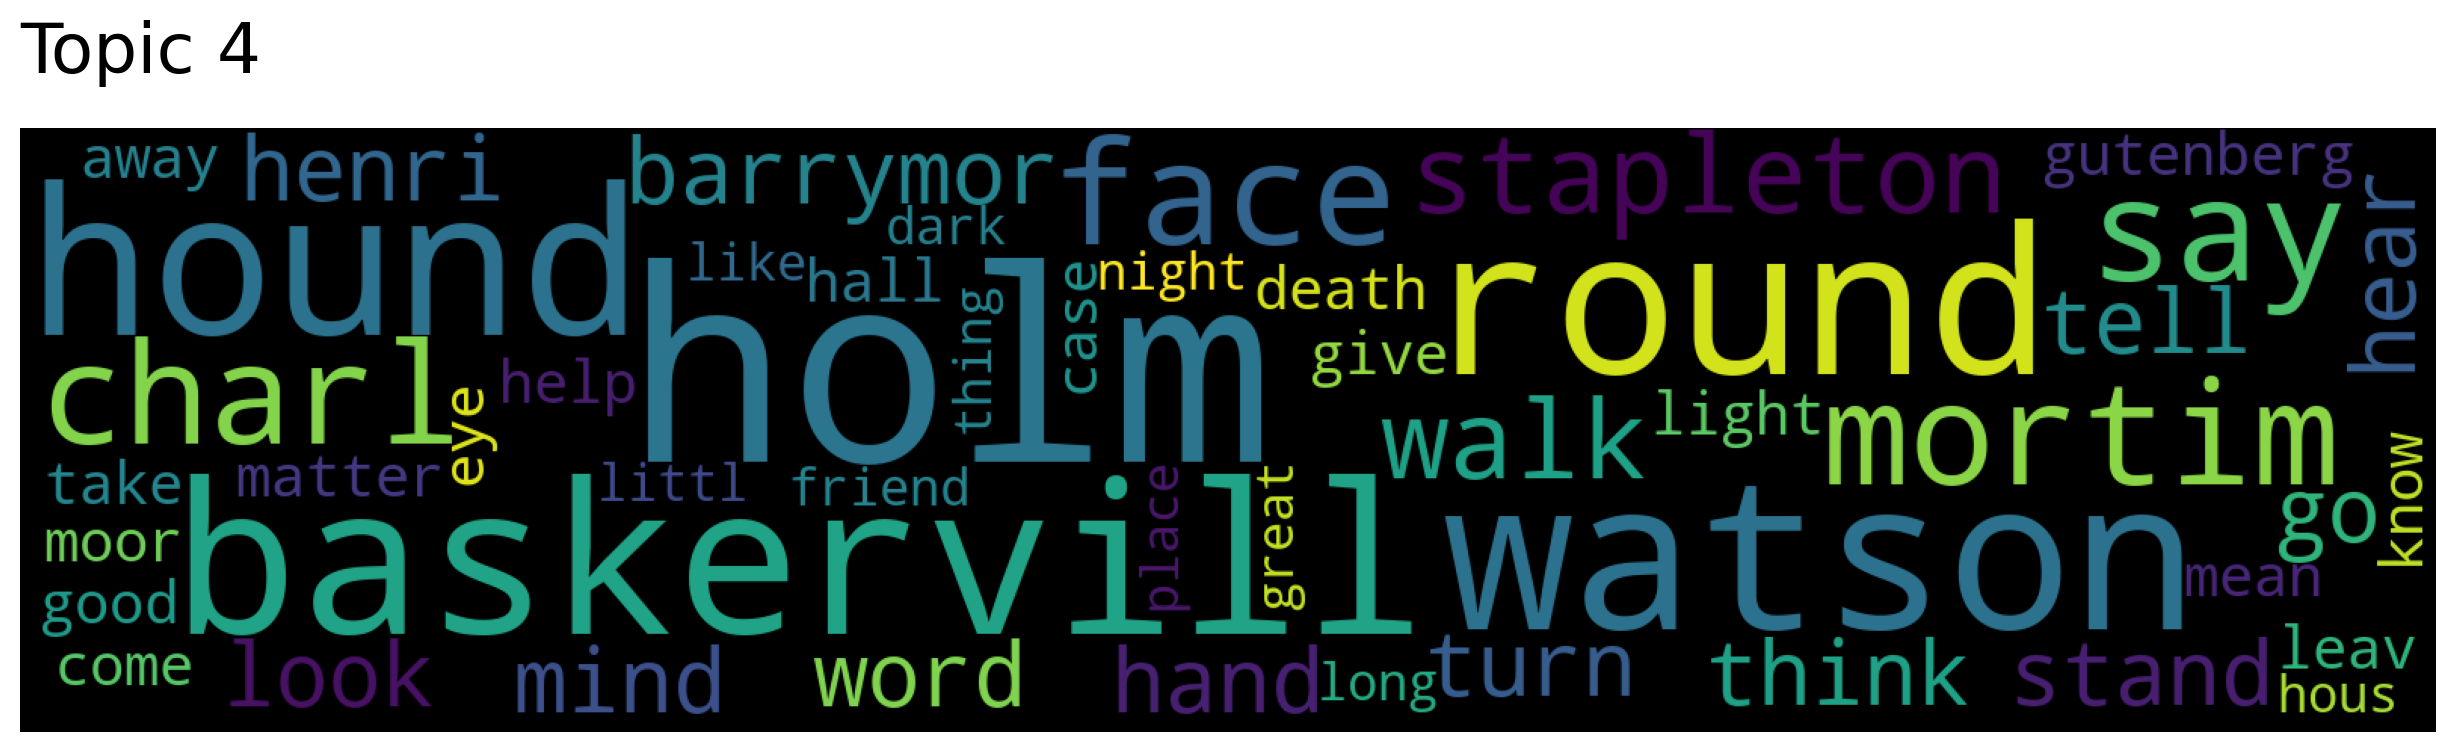

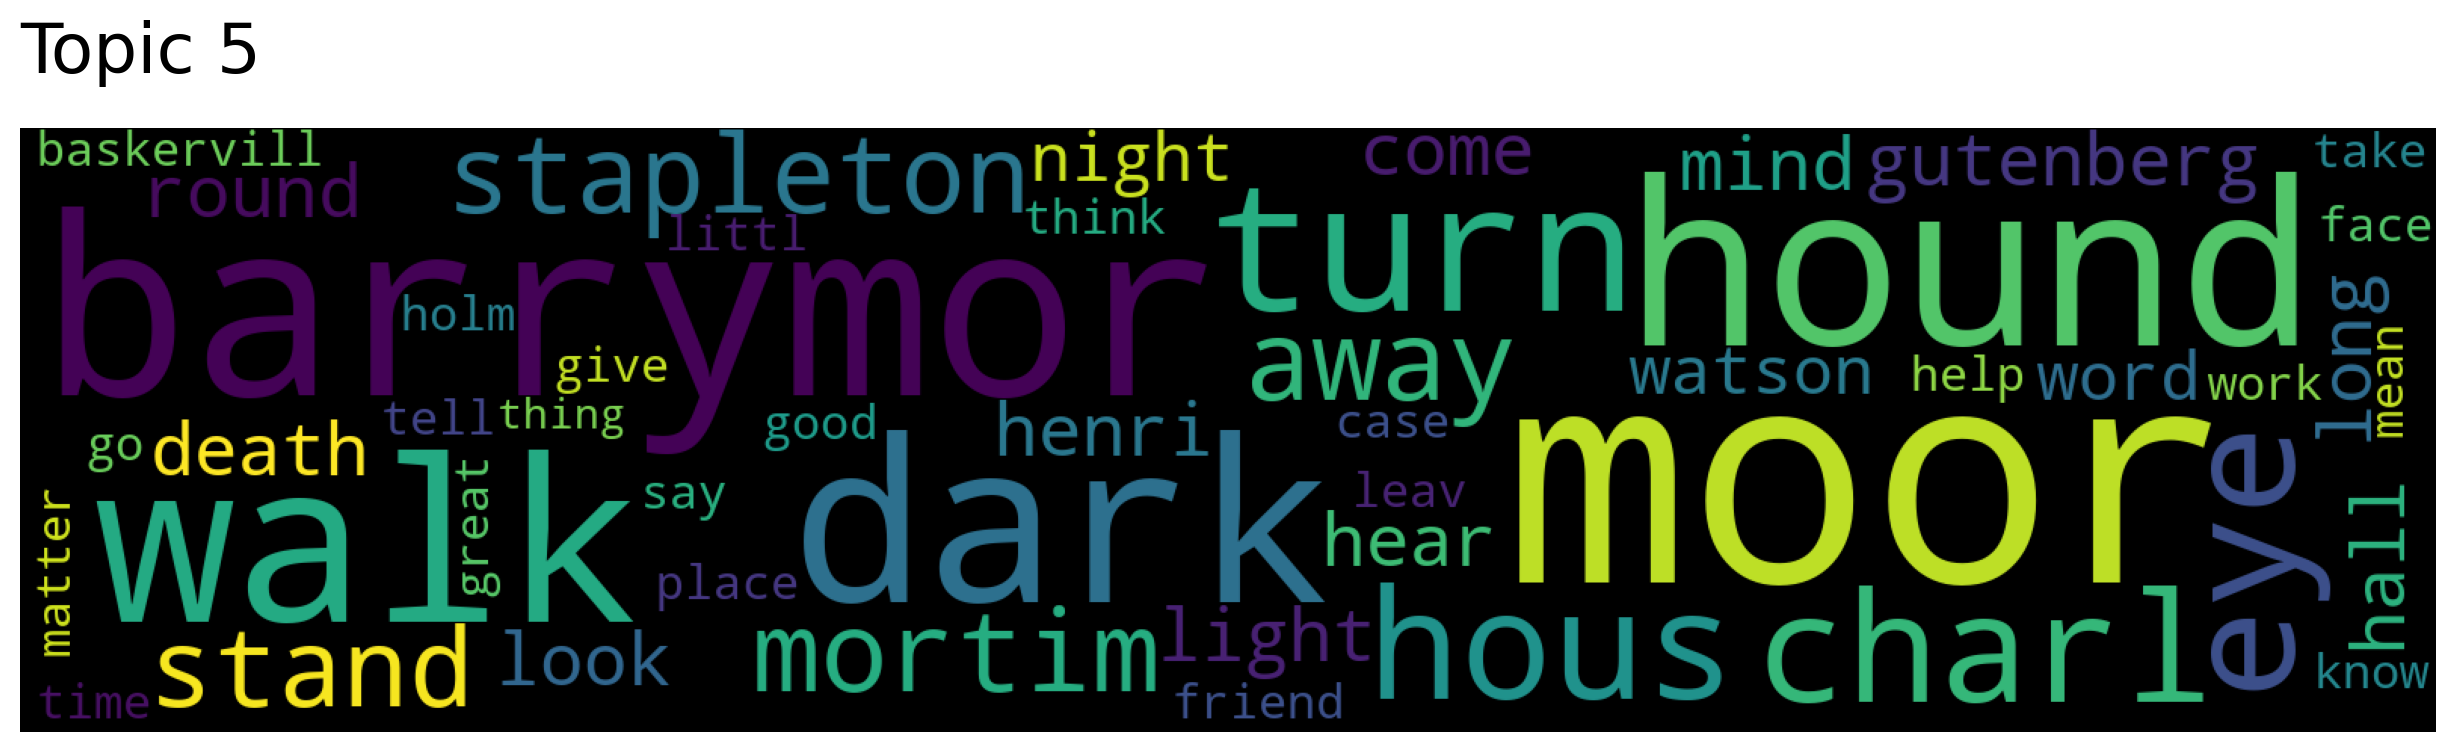

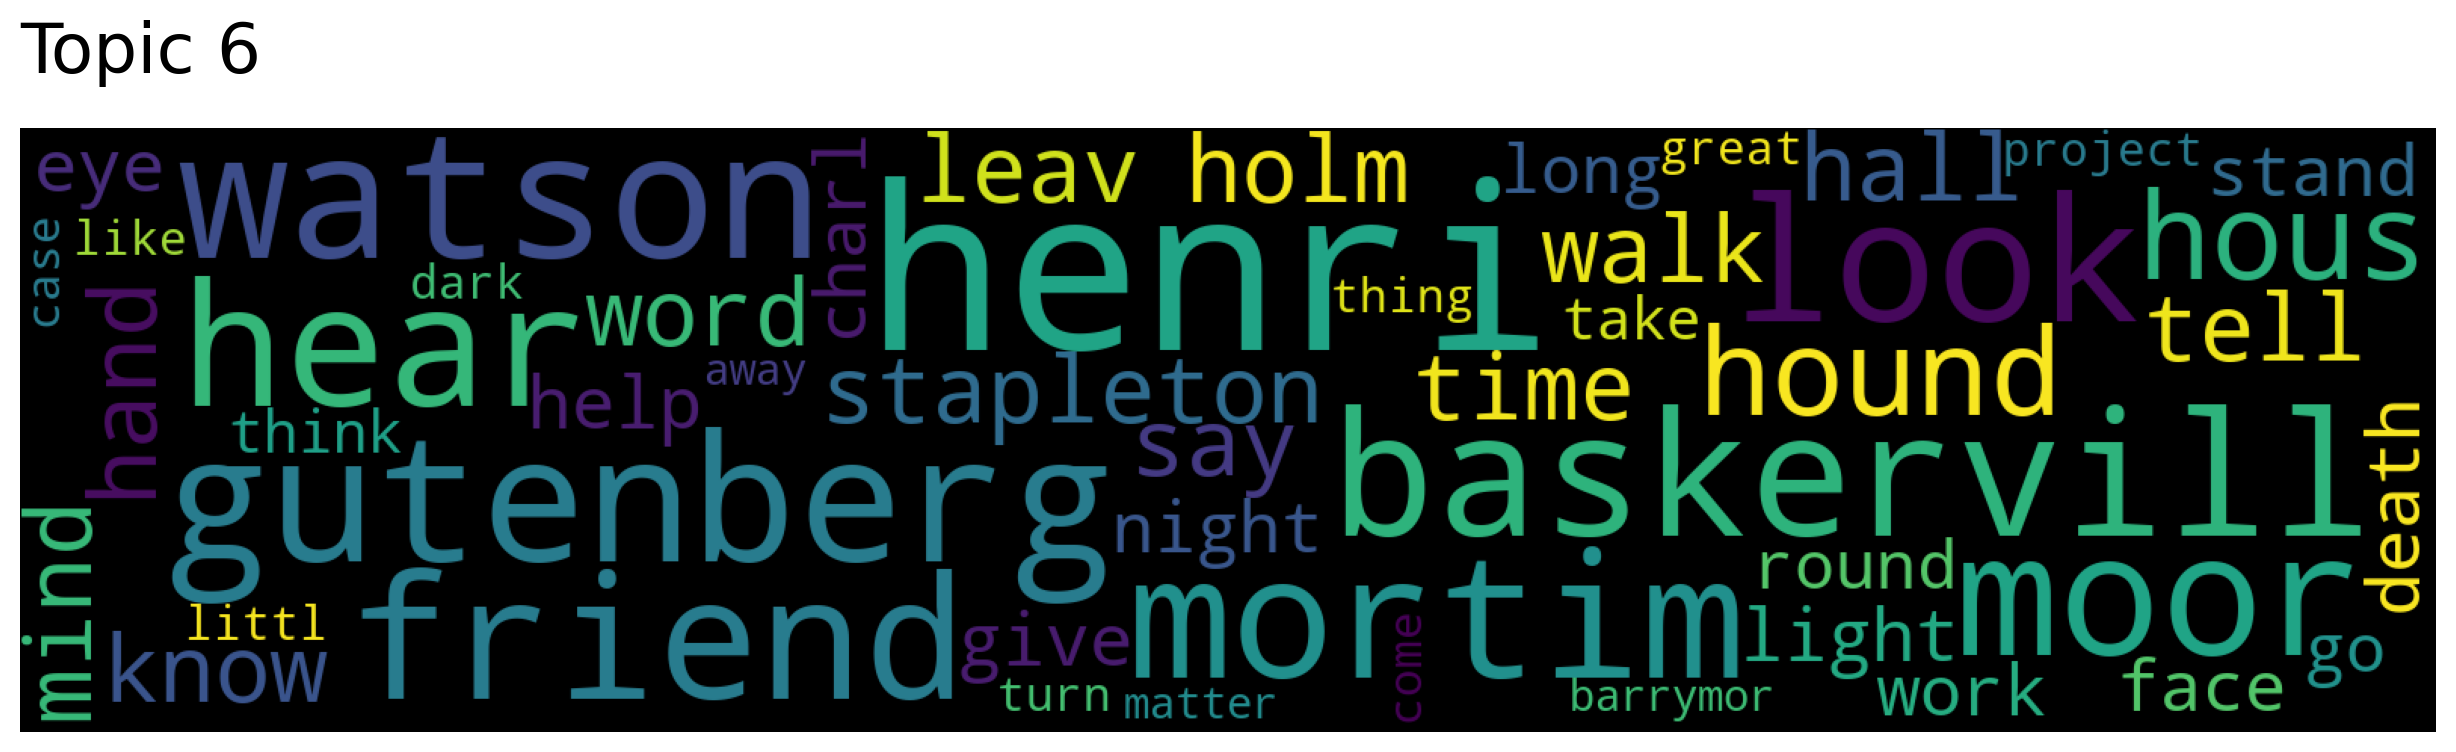

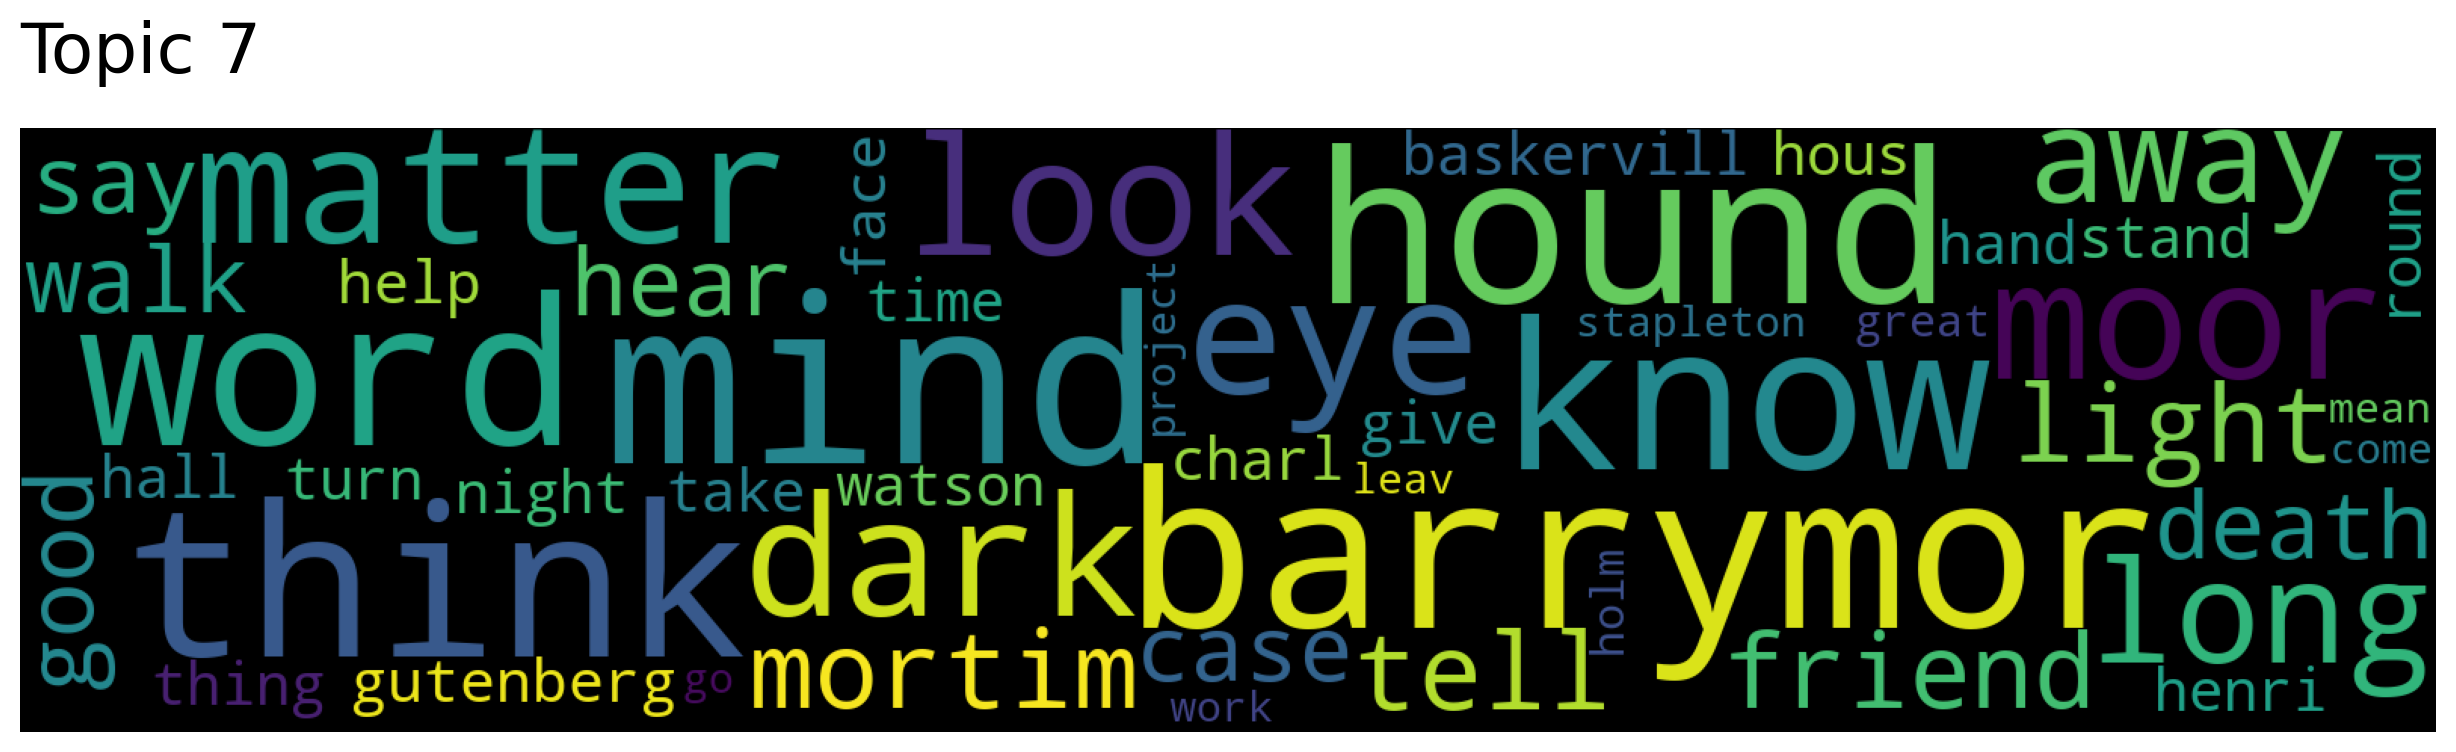

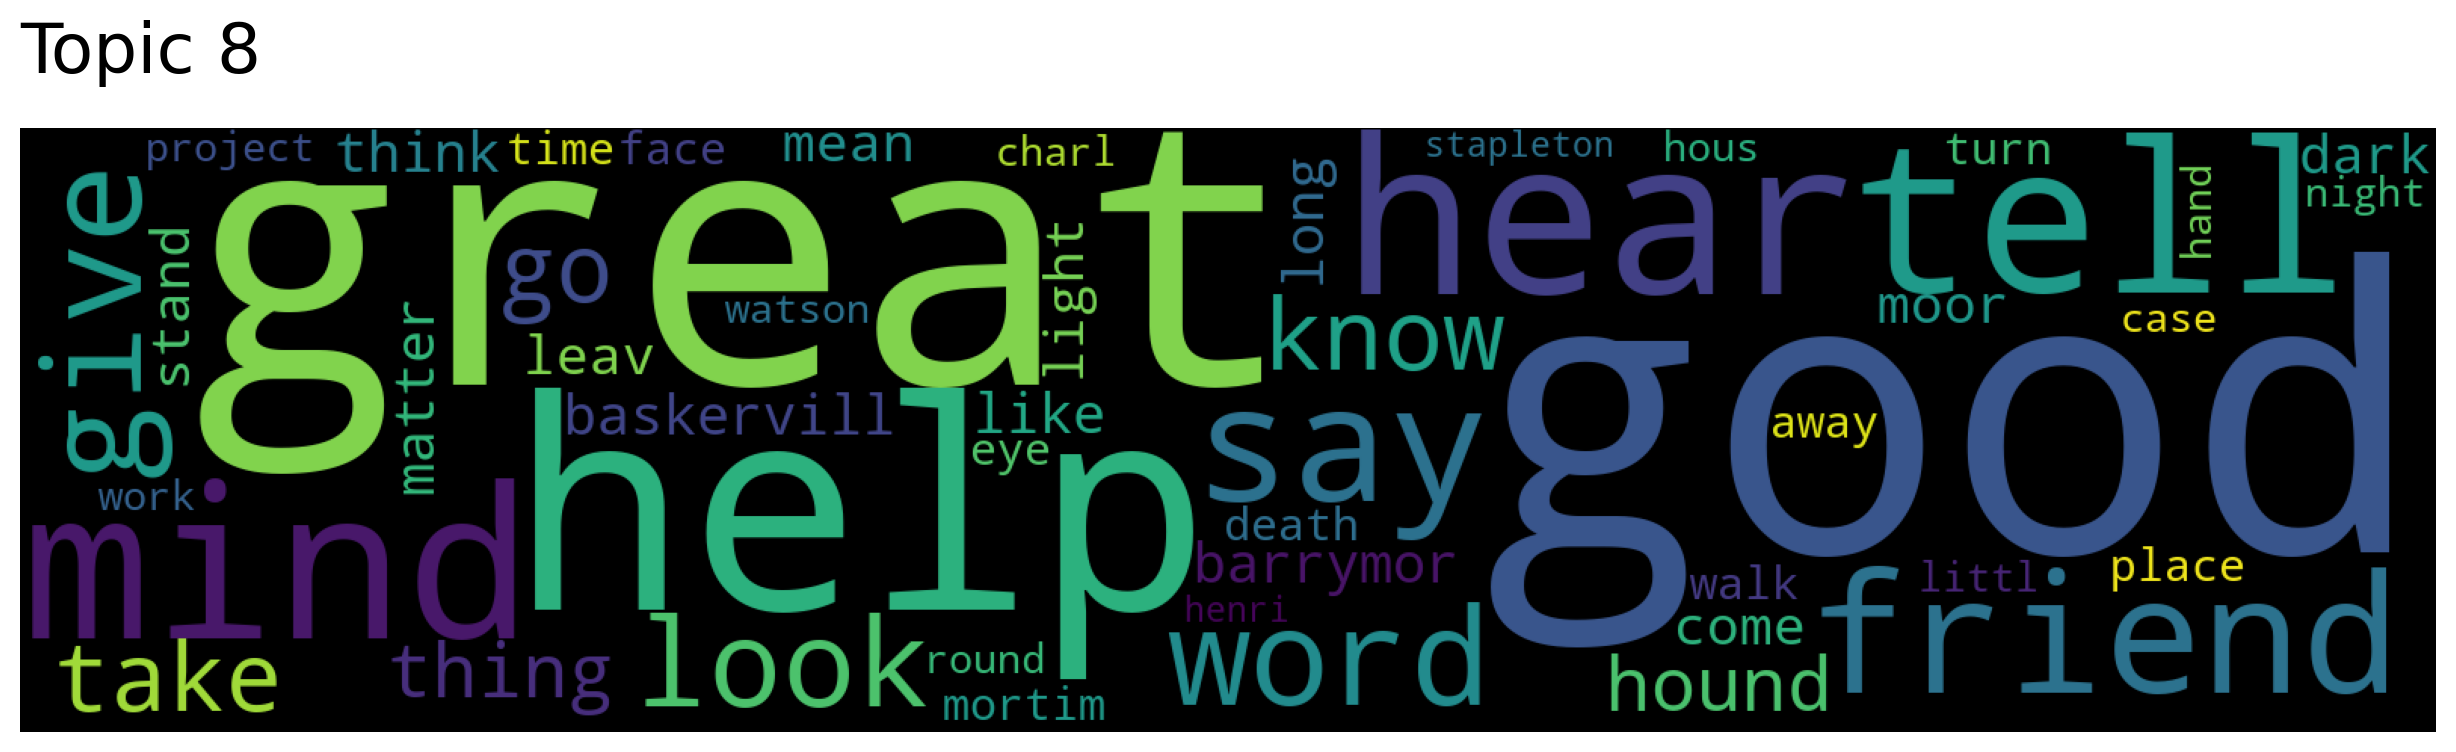

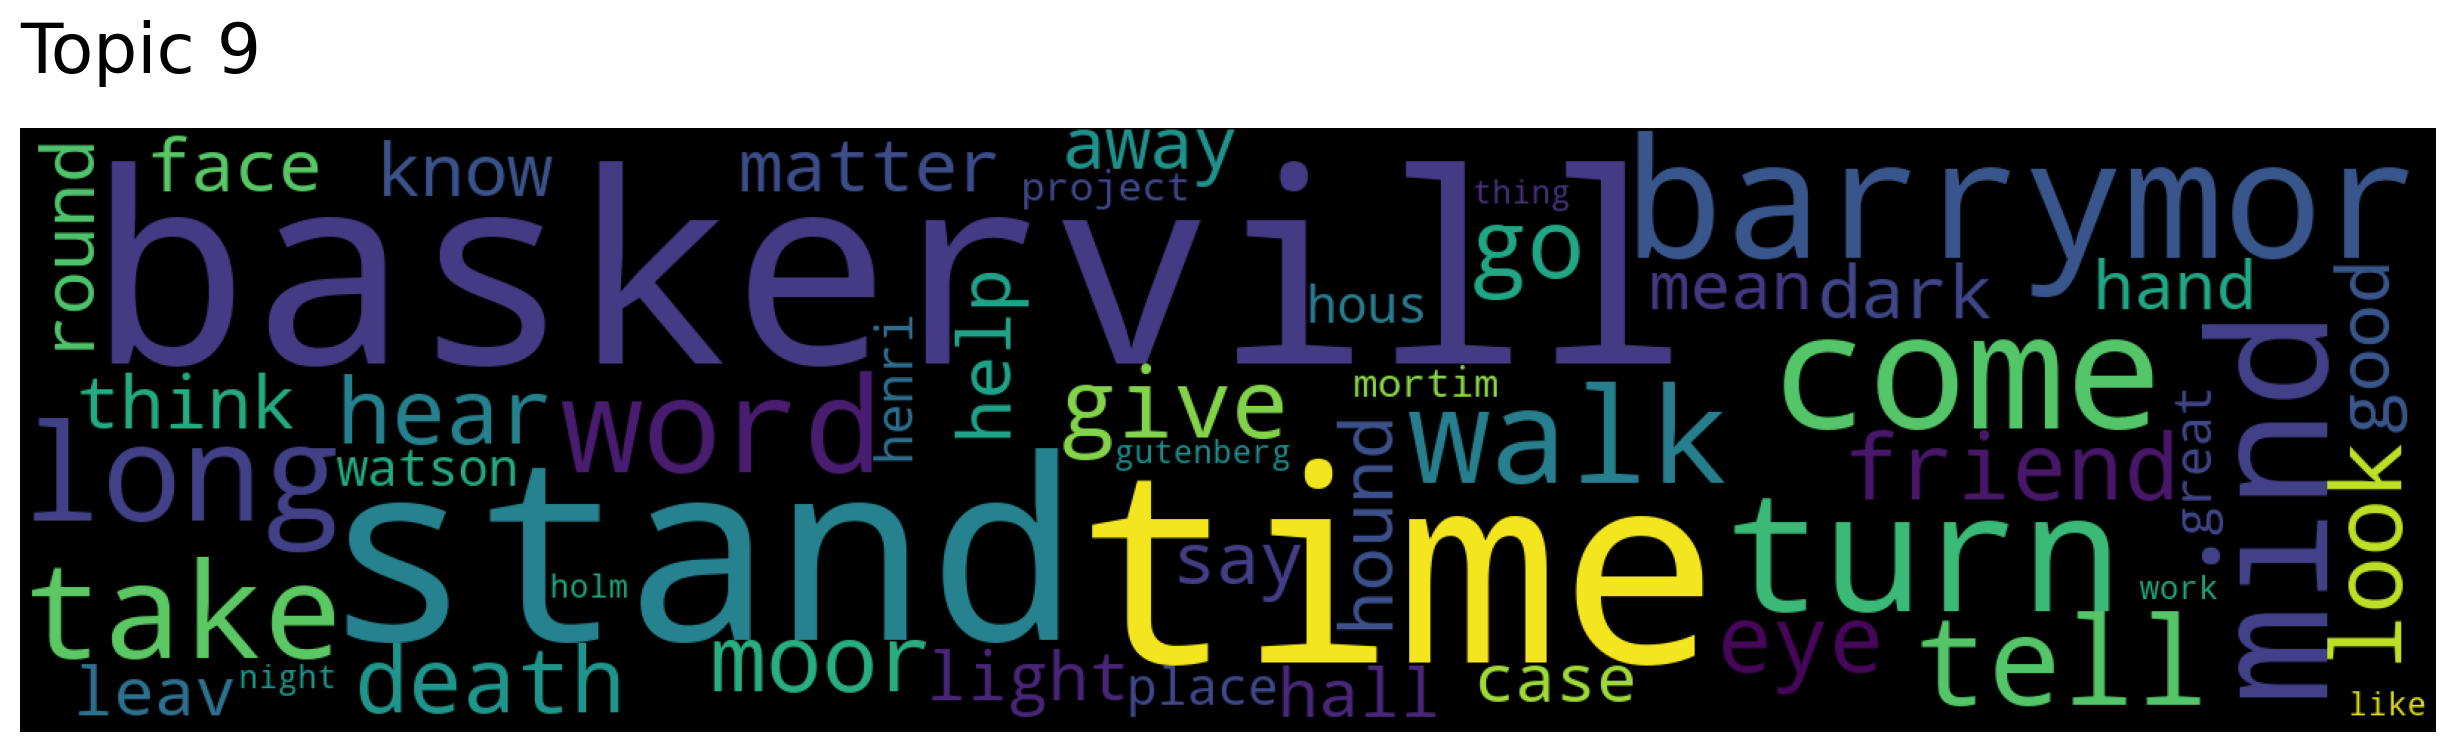

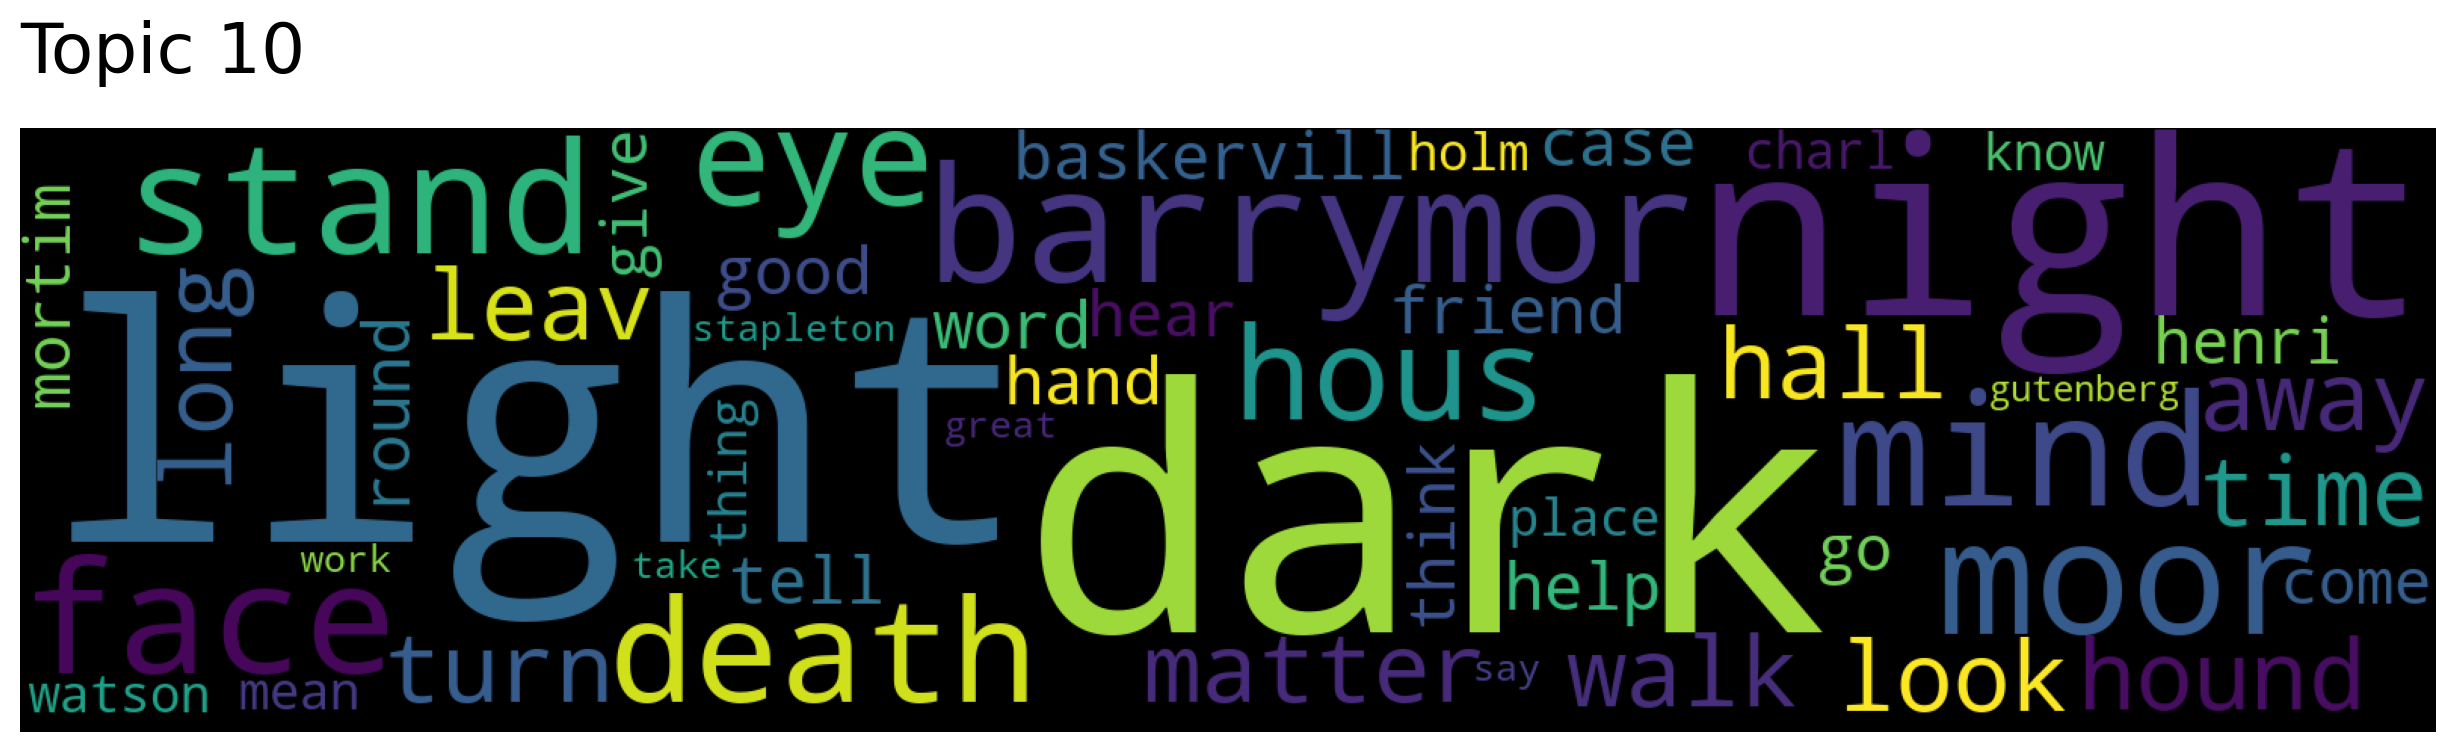

In [ ]:
for i in range(0,11):
 model.generate_topic_wordcloud(i)

As we can see Top2Vec model is not performing that well since it tags same words to all topics which are frequently appearing . The semi-supervised model of Anchored CorEx model is providing much better results and helping us uncover major topics related to the book "Hounds of Baskervilles Sherlock" such as "Animal","Lanscapes","Crime/Thriller" etc.

## Conclusion

Anchored Cor-Ex model gives better results. 

Further work can be explored using other models such as LDA2Vec